# IFT6269 - Homework 5 - Sampling Methods
**Due:**  Monday, December 23, 2024

#### Name: Grégoire Barrette
#### Student ID: 20175180
#### Collaborators: None

In [226]:
import numpy as np
np.random.seed(0)
np.set_printoptions(precision=5, suppress=True)
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

# ---------------------------------------------------------------------------
#                       Code for plotting the results
#                      ! DO NOT MODIFY THIS FUNCTION !
# ---------------------------------------------------------------------------

def show_matrix(A):
    matfig = plt.figure(figsize=(5,5))
    plt.matshow(A, cmap=plt.cm.plasma, fignum=matfig.number)
    plt.colorbar()
    plt.show()

def plot_list(data, title=""):
    plt.figure(figsize=(5,2))
    plt.plot(data)
    plt.title(title)
    plt.show()

## Tasks

0. Get your own copy of this file via "File > Save a copy in Drive...",
1. Fill your personal information and collaborators at the top of this assignment, and rename the notebook accordingly, e.g., `hw5_thomasBayes.ipynb`
2. Read the instructions provided on each section and cell carefully,
5. Complete the coding exercises in sections **Gibbs sampling** and **Mean field**.
    
**Important**: You are allowed to collaborate with other students in both the math and coding parts of this assignment. However, the answers provided here must reflect your individual work. For that reason, you are not allowed to share this notebook, except for your submission to the TA for grading. **Don't forget to pin and save the version of the notebook you want to be graded on!**

## Problem setting

Consider the Ising model with binary variables $X_s \in \{0,1\}$ and a factorization of the form:
$$
p(x; \eta) = \frac{1}{Z_p} \exp \left( \sum_{s \in V} \eta_s x_s + \sum_{\{s,t\} \in E} \eta_{st} x_s x_t \right).
$$
We consider the 7 $\times 7$ two-dimensional grid as shown below. Note that we used toroidal (donut-like) boundary conditions to make the problem symmetric. We will consider approximate inference methods to approximate the node marginal moments $\mu_s := p(X_s = 1)$ in this model.

<center><img src="https://imgur.com/Q1u6m5U.png" alt="drawing" width="350"/>


## Gibbs sampling

**Implementation**

Using the update equations you found in the theoretical part of the assignment, implement the Gibbs sampling algorithm (with cyclic sequential traversal of the nodes) for $\eta_{st} = 0.5$ for all edges, and $\eta_s = (-1)^s$ for all $s \in \{1, \ldots, 49\}$ (using the node ordering in the figure).

In [227]:
def sigmoid(x):
    """
    Sigmoid function defined as \sigma(x) = exp(x) / (1 + exp(x))

        Inputs:
            x: [d] a d-dimensional vector
        
        Returns:
            \sigma(x): simoid function applied elementwise to x
    """

    sigma = np.exp(x) / (1 + np.exp(x))

    return sigma

def gibbs_sampling(X0, burn_in, num_epochs):

    """
    Performs Gibbs sampling on the UGM

        Inputs:
            X0: [7 x 7] matrix representing the initial state of the grid shown
               in the picture. X[0, 0] is the variable numbered 1.
            burn_in: [int] burn-in period
            num_epochs: [int] number of epochs (one epoch amounts to updating
               *each* node once)

        Returns:
            samples: [num_epochs x 7 x 7] tensor of generated samples for each
                of the epochs after the burn-in period. Here this corresponds to
                num-epoch matrices of size 7 x 7.
    """
    # useful constants
    k, l = X0.shape
    
    eta_st = 0.5
    eta_s = -1

    samples = np.random.rand(num_epochs, k, l)
    samples[0, ...] = X0

    for e in range(1,num_epochs):

        for i in range(k):
            for j in range(l):
                # compute \eta_s + \sum_{t\in N(s)}\eta_st x_t
                update = eta_s**(k*(i)+(j+1)) + eta_st * \
                (samples[e, (i-1)%k, j]+samples[e, (i+1)%k, j]+samples[e, i,(j-1)%l]+samples[e, i, (j+1)%l])
                
                # computing p(x_s) = 1
                prob = sigmoid(update)

                # sampling from a Bernoulli distribution to assign new node value
                if np.random.binomial(1, prob) == 1:
                    samples[e, i, j] = 1
                else:
                    samples[e, i, j] = 0
                
    # returning samples after burn-in period
    return samples[burn_in:, ...]

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/var/folders/3b/syn17q895x76ff4c_qs9zz400000gn/T/ipykernel_33776/3915863695.py:2: SyntaxWarning: invalid escape sequence '\s'
  """


**Execution**

Run a *burn-in period* of 1000 epochs (where **one epoch amounts to updating each node once**). For each of the 5000 *subsequent epochs*, collect a sample vector. Use the 5000 samples to form Monte Carlo estimates $\hat{\mu}_s$ of the moments $\mathbb{E}[X_s]$ at each node. Create a $7 \times 7$ matrix of the estimated moments.


**Note:** We mentioned in class that every update of a node yields a *different* sample in theory, and that one should normally use *all* the available samples (after sufficient mixing) for a Monte Carlo estimate. In this case, that would be $49$ (one for each individual node update) times $5000$ epochs. But note that using all these samples would give almost the exact same estimates, only differing from the boundary conditions during the first and last epoch. Do NOT use the 49x5000 different samples!

[[0.5046 0.8756 0.544  0.8798 0.5456 0.8764 0.5428]
 [0.8808 0.6046 0.884  0.5926 0.8848 0.6012 0.9072]
 [0.549  0.8802 0.5942 0.8814 0.5856 0.884  0.5866]
 [0.882  0.5954 0.8864 0.602  0.887  0.5836 0.9076]
 [0.546  0.873  0.5884 0.8818 0.586  0.8812 0.586 ]
 [0.8674 0.5952 0.8914 0.602  0.8814 0.5896 0.904 ]
 [0.5402 0.8976 0.603  0.8998 0.605  0.8978 0.606 ]]


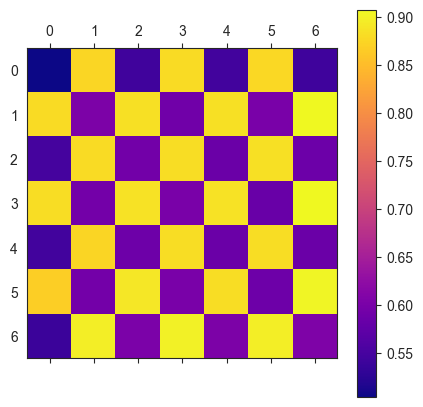

In [228]:
# Keep this initialization scheme
X0 = 1.0 * (np.random.rand(7, 7) > 0.5)

# Running Gibbs sampling function
samples = gibbs_sampling(X0, burn_in=1000, num_epochs=6000) # num_epoch was set to 5000 but we need 5000 epochs AFTER burn-in time

# Using the samples to perform the Monte Carlo estimates for \hat{mu}_s
mu_hat = np.sum(samples, axis = 0) / samples.shape[0]

# # Do NOT change these last two lines
print(mu_hat)
show_matrix(mu_hat)

Repeat the experiment $10$ times and output a $7 \times 7$ matrix of the empirical standard deviation of your estimate at each node (this gives an idea of the variability of your estimates).

[[0.00694 0.00316 0.00523 0.0046  0.0073  0.00343 0.00483]
 [0.00423 0.00452 0.00449 0.00926 0.00535 0.00727 0.00308]
 [0.00879 0.00315 0.00925 0.00338 0.00865 0.00582 0.00534]
 [0.00336 0.0083  0.00315 0.0086  0.00304 0.00494 0.00499]
 [0.00437 0.00526 0.01082 0.00559 0.00412 0.00296 0.00477]
 [0.00467 0.00934 0.0034  0.00449 0.00336 0.00732 0.00438]
 [0.00699 0.00497 0.00488 0.00207 0.00587 0.00304 0.00591]]


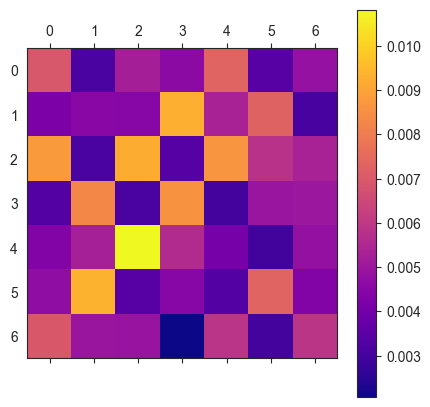

In [229]:
N_trials = 10

mu_hat = np.zeros((N_trials, 7, 7))

for trial in range(N_trials):
    samples = gibbs_sampling(X0, burn_in = 1000, num_epochs = 6000)
    mu_hat[trial, ...] = np.sum(samples, axis = 0) / (samples.shape[0])
    
mu_hat_std = np.std(mu_hat, axis = 0)

# Do NOT change this last line
print(mu_hat_std)
show_matrix(mu_hat_std)

## Mean field

**Implementation**

Implement the mean field updates you derived in the theoretical part for the same mode. Use the same $\eta_s$ and $\eta_{st}$ as above. Recall we use the notation $q(X_s =1) = \tau_s$. More specifically, do cyclic coordinate descent on $KL(q || p)$, sequentially updating the parameter $\tau_s \in [0,1]$ for $s \in \{1, \ldots, 49\}$.

Let $d(\tau, \tau'):= \frac{1}{49} \sum_{s=1}^{49} |\tau_s - \tau'_s|$ be the average $\ell_1$ distance between two parameters. Use $d(\tau^{(k-1)}, \tau^{k}) <  0.001$ as a stopping criterion for convergence, where $k$ counts the number of **epochs**.  Compute $KL(q || p)-\log(Z_p)$ as a function of the number of epochs both for debugging purpose and monitor progress.

In [230]:
def distance(tau, tau_prime):
    """
    Computes the average l_1 distance between two parameter configurations

        Inputs:
            tau: [k x l] array
            tau_prime: [k x l] array
        
        Returns: l_1 distance between tau and tau_prime

    """
    
    assert tau.shape == tau_prime.shape, "tau and tau_prime must have the same shape"

    N = tau.size # number of elements in tau and tau prime
    diff = np.abs(tau - tau_prime) # absolute element-wise distance  

    return np.sum(diff) / N # l_1 norm

def kl_minus_log(tau):
    """
    Computes KL(q(tau) || p) - log(Z_p) = \sum_s[tau_s * log(tau_s) +(1-tau_s) * log(1-tau_s)]
    - \sum_s eta_s * tau_s - \sum_{s, t\in E} eta_st * tau_s * tau_t = q_part - p_part

        Input:
            tau: [k x l] array
        
        Returns:
            KL(q(tau) || p) - log(Z_p): [scalar] where p is the Ising probability distribution and Z_p its partition function
    """

    # useful dimensions
    k, l = tau.shape

    eta_s = -1  # external field
    eta_st = 0.5 # coupling strength
    eps = 1e-10 # for log stability 
 
    q_part = np.sum(tau * np.log(tau + eps) + (1-tau) * np.log(1-tau + eps))
    p_part = np.zeros((k, l))

    for i in range(k):
        for j in range(l):
            p_part[i, j] = eta_s ** (k*(i)+(j+1)) * tau[i, j] + eta_st * tau[i, j] * \
            (tau[(i-1)%k, j] + tau[(i+1)%k, j] + tau[i,(j-1)%l] + tau[i, (j+1)%l])

    return q_part - np.sum(p_part)

def mean_field(tau0, dist_tol):
    """
    Mean field approximation for the UGM

        Inputs:
            tau0: [7 x 7] matrix representing the initial value of the parameters
               tau_s for each state of the grid shown in the picture. tau[0, 0]
               is the parameter associated to the variable numbered 1.
            dist_tol: [float] tolerance between epochs. If change in parameter
               between two subsequent *epochs* is less than dist_tol, stop.

        Returns:
            tau: [7 x 7] matrix of parameters at convergence.
            d_hist: [list] list of parameter distance between subsequent epochs.
                d_hist[0] = d(tau_0, tau_1) and so on.
            kl_hist: [list] list containing KL(q||p) - log(Z_p).
                kl_m_log[0] = KL(q(tau_0)||p) - log(Z_p) and so on.
    """

    # useful constants
    k, l = tau0.shape

    eta_s = -1 # external field
    eta_st = 0.5 # coupling strength

    tau = tau0.copy()
    d_hist = []
    kl_hist = [kl_minus_log(tau)]

    while True:
        tau_prev = tau.copy()

        for i in range(k):
            for j in range(l):
                # computing eta_s + \sum_{t \in N(s)} eta_st * tau_t
                update = eta_s ** (k*(i)+(j+1)) + eta_st * \
                (tau[(i-1)%k, j] + tau[(i+1)%k, j] + tau[i,(j-1)%l] + tau[i, (j+1)%l])

                tau[i,j] = sigmoid(update)

        dist = distance(tau, tau_prev)
        d_hist.append(dist)
        kl_hist.append(kl_minus_log(tau))

        # convergence criterion
        if dist < dist_tol:
            break
        
    return tau, d_hist, kl_hist

<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
/var/folders/3b/syn17q895x76ff4c_qs9zz400000gn/T/ipykernel_33776/3362131586.py:21: SyntaxWarning: invalid escape sequence '\s'
  """


**Execution**

Run your algorithm and plot the mean field estimated moments. Plot the behavior of $d(\tau^{(k-1)}, \tau^{k})$ and $KL(q(\tau^k) || p) -\log(Z_p)$.

[[0.63585 0.92154 0.67167 0.92286 0.67167 0.92154 0.63585]
 [0.92154 0.69783 0.91543 0.69742 0.91543 0.69783 0.92154]
 [0.67167 0.91543 0.69673 0.91636 0.69673 0.91543 0.67167]
 [0.92286 0.69742 0.91636 0.69693 0.91636 0.69742 0.92286]
 [0.67167 0.91543 0.69673 0.91636 0.69673 0.91543 0.67167]
 [0.92154 0.69783 0.91543 0.69742 0.91543 0.69783 0.92154]
 [0.63585 0.92154 0.67167 0.92286 0.67167 0.92154 0.63585]]


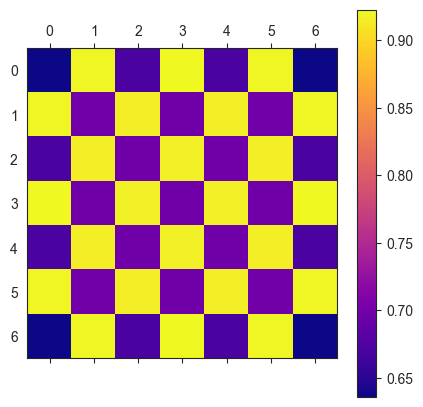

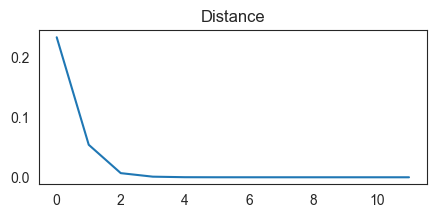

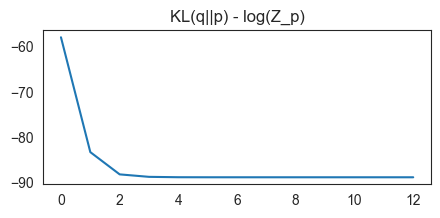

In [231]:
# Keep this initialization for reproducibility
tau0 = 0.5 * np.ones((7, 7))

# We run your mean field function
tau, d_hist, kl_hist = mean_field(tau0, dist_tol=1e-10)

# Do NOT change these last lines
print(tau)
show_matrix(tau)
plot_list(d_hist, 'Distance')
plot_list(kl_hist, 'KL(q||p) - log(Z_p)')

Try $5$ different initializations for $\tau$ and compute $d(\hat{\tau}_s, \hat{\mu}_s)$ between the mean field estimated moments $\hat{\tau}_s$ and the Gibbs estimates $\hat{\mu}_s$.

Distance between mean field estimate and Gibbs estimate for trial 1: 0.0677149335847538


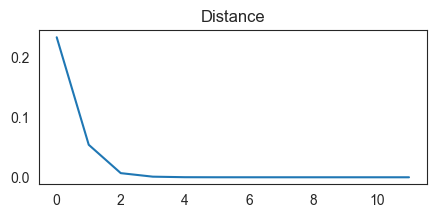

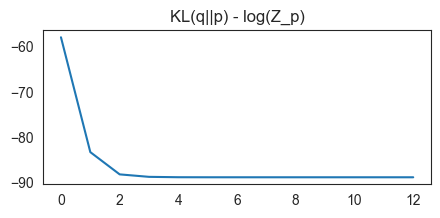

Distance between mean field estimate and Gibbs estimate for trial 2: 0.06761697440108032


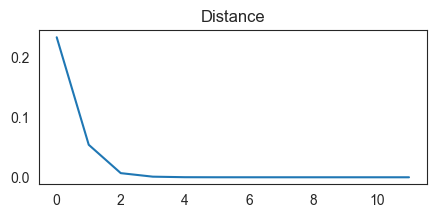

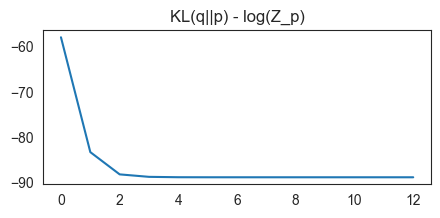

Distance between mean field estimate and Gibbs estimate for trial 3: 0.06755983154393747


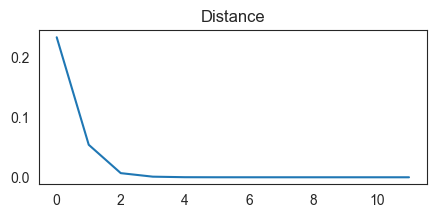

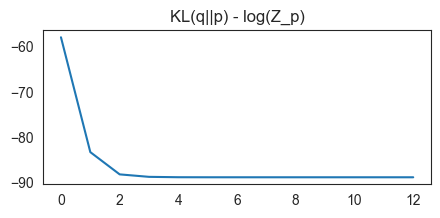

Distance between mean field estimate and Gibbs estimate for trial 4: 0.06712717848271298


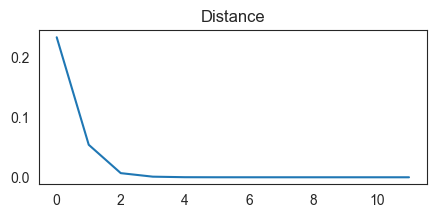

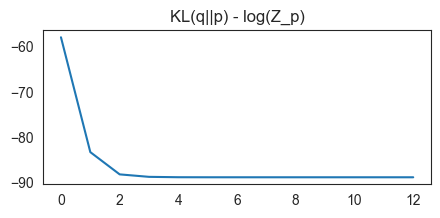

Distance between mean field estimate and Gibbs estimate for trial 5: 0.06770677031944768


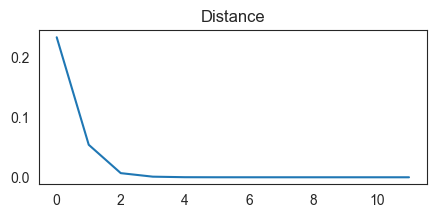

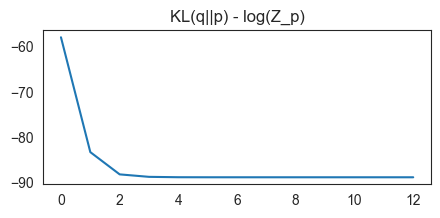

In [232]:
i = 1
for trial in range(5):

    # random tau init
    tau0 = 0.5 * np.ones((7, 7))
    # sample the intial Ising states X0[i,j] from a Bernoulli with parameter tau[i,j]
    # to ensure consistency with mean field
    X0 = np.random.binomial(1,tau0)

    tau, d_hist, kl_hist = mean_field(tau0, dist_tol=1e-10) # mean field estimate for tau_s
    
    samples = gibbs_sampling(X0, burn_in=1000, num_epochs=6000) # gibbs sampling algorithm
    mu_hat = np.sum(samples, axis = 0) / samples.shape[0] # gibbs estimate for mu_s

    print(f'Distance between mean field estimate and Gibbs estimate for trial {i}: {distance(tau, mu_hat)}')
    plot_list(d_hist, 'Distance')
    plot_list(kl_hist, 'KL(q||p) - log(Z_p)')
    i += 1

**Question:** Is the mean field a good approximation here? Does it get stuck in different local minima?

**Answer:**
The distance between the Gibbs and the mean field estimates is always around 0.066. Because it is consistently around that value, I think it gets stuck in a different minima each time and because the distance between estimates is somewhat large, I will say that mean field is not really a good approximation here. Indeed, mean field assumes a fully factorized distribution over the variables, which is not true for the Ising model because of the coupling between nodes $\eta_{st}$. The coupling $\eta_{st} = 0.5$ might be too strong in this case. 

I think that it gets stuck in a different local minima because in mean field we are optimizing a simplified objective, namely the KL divergence. Gibbs sampling on the other hand is a Markov Chain Monte Carlo which samples the from the true joint probability distribution.